<a href="https://colab.research.google.com/github/LarsHadidi/PRONTO/blob/mathprogram/mp/PDP-AQC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progressive Dinner Party: Adiabatic Quantum Computation

## Hosted Runtime

In [ ]:
!pip install -q dwave-ocean-sdk

## Imports

In [33]:
import dimod
import pickle
import getpass
import itertools
import numpy as np
import networkx as nx
import ipywidgets as widgets
from google.colab import files
import matplotlib.pyplot as plt
from dwave.system import LeapHybridCQMSampler 

## Data

In [3]:
w_size = widgets.IntText(description='Size', orientation='horizontal', value=9, min=9)
w_cluster = widgets.IntText(description='Clusters', orientation='horizontal', value=1, min=1)
w_deviation = widgets.FloatText(description='Deviation', orientation='horizontal', value=0.1, min=0)
w_scale = widgets.IntText(description='Scaling', orientation='horizontal', value=1)
display(widgets.Box([w_size, w_cluster,w_deviation, w_scale], layout=widgets.Layout(display='flex', flex_flow='row')))

Box(children=(IntText(value=9, description='Size'), IntText(value=1, description='Clusters'), FloatText(value=…

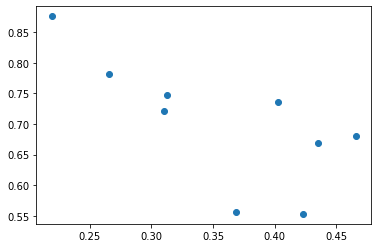

In [4]:
rng = np.random.default_rng()

N = w_size.value
K = w_cluster.value
σ = w_deviation.value
λ = w_scale.value

assert N >= 9
assert K > 0
assert N % K == 0
assert N % 3 == 0
assert σ >= 0
assert λ > 0

points = {}
centers = rng.uniform(-1, 1, (K, 2))
for i in range(K):
	points[str(centers[i])] = λ * rng.normal(centers[i], σ, (N // K, 2))

X = np.array(list(points.values())).reshape(N, 2)[:,0]
Y = np.array(list(points.values())).reshape(N, 2)[:,1]

G = nx.DiGraph()
for i in range(N):
	G.add_node(i, x = X[i], y = Y[i])

C = np.empty((N,N))
for a,b in itertools.product(range(N), range(N)):
	dX = (X[b]-X[a]) * (X[b]-X[a])
	dY = (Y[b]-Y[a]) * (Y[b]-Y[a])
	C[a,b] = np.sqrt(dX + dY)

plt.scatter(X,Y)
plt.show()

## Draft

In [5]:
cqm = dimod.ConstrainedQuadraticModel()

In [6]:
N = 9

e = [[dimod.Binary(f'e_{i}_{j}') for j in range(N)] for i in range(N)]
s = [dimod.Binary(f's_{i}') for i in range(N)]
m = [dimod.Binary(f'm_{i}') for i in range(N)]
d = [dimod.Binary(f'd_{i}') for i in range(N)]

cqm.set_objective(dimod.quicksum(C[i,j] * e[i][j] for i,j in itertools.product(range(N), range(N))))

for i in range(N):
  cqm.add_constraint(s[i] + m[i] + d[i] == 1)
  
  cqm.add_constraint(dimod.quicksum( s[i] * e[j][i] for j in range(N) ) == 0)
  cqm.add_constraint(dimod.quicksum( s[i] * e[i][j] for j in range(N) ) - 3 * s[i] == 0)

  cqm.add_constraint(dimod.quicksum( m[i] * e[j][i] for j in range(N) ) - 3 * m[i] == 0)
  cqm.add_constraint(dimod.quicksum( m[i] * e[i][j] for j in range(N) ) - 3 * m[i] == 0)

  cqm.add_constraint(dimod.quicksum( d[i] * e[j][i] for j in range(N) ) - 3 * d[i] == 0)
  cqm.add_constraint(dimod.quicksum( d[i] * e[i][j] for j in range(N) ) == 0)

  cqm.add_constraint(dimod.quicksum(m) * 3 == N)

for i,j in itertools.product(range(N), range(N)):
  cqm.add_constraint(s[i] * e[i][j] + d[j] <= 1)

In [7]:
sampler = LeapHybridCQMSampler(token=getpass.getpass())
sampleset = sampler.sample_cqm(cqm, label="PDP Optimization")

··········


In [26]:
print(f"QPU Time: {sampleset.info['qpu_access_time'] / 1e6:06.3f}s")

QPU Time: 00.016s


In [34]:
sol = sampleset.filter(lambda sample: sample.is_feasible).lowest().to_pandas_dataframe(sample_column=True)

In [38]:
with open('solution', 'wb') as f:
  pickle.dump(sol, f)

files.download('solution')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
with open('solution', 'rb') as f:
  sol = pickle.load(f)

In [42]:
sol

,sample,energy,num_occurrences,is_satisfied,is_feasible
0,"{'d_0': 1.0, 'd_1': 0.0, 'd_2': 0.0, 'd_3': 0....",2.64064,1,"[True, True, True, True, True, True, True, Tru...",True
1,"{'d_0': 1.0, 'd_1': 0.0, 'd_2': 0.0, 'd_3': 0....",2.64064,1,"[True, True, True, True, True, True, True, Tru...",True
2,"{'d_0': 1.0, 'd_1': 1.0, 'd_2': 0.0, 'd_3': 0....",2.64064,1,"[True, True, True, True, True, True, True, Tru...",True
3,"{'d_0': 0.0, 'd_1': 0.0, 'd_2': 0.0, 'd_3': 0....",2.64064,1,"[True, True, True, True, True, True, True, Tru...",True
4,"{'d_0': 1.0, 'd_1': 0.0, 'd_2': 0.0, 'd_3': 0....",2.64064,1,"[True, True, True, True, True, True, True, Tru...",True


In [56]:
smp = sol.iloc[0]['sample']

In [63]:
s = np.array([smp[f's_{i}'] for i in range(N)])
m = np.array([smp[f'm_{i}'] for i in range(N)])
d = np.array([smp[f'd_{i}'] for i in range(N)])
e = np.array([[smp[f'e_{i}_{j}'] for j in range(N)] for i in range(N)])

## Results

In [79]:
def draw_graph(nodes: dict, edges: list):
	G = nx.DiGraph()
	G.add_nodes_from(nodes)
	G.add_edges_from(edges)
	pos = {k: list(v.values()) for k, v in nodes.items()}
	node_colors = np.array(list(dict(G.in_degree(G.nodes)).values())) - np.array(list(dict(G.out_degree(G.nodes)).values()))

	nx.draw(
			G, pos,
			node_color = node_colors,
			width=3, node_size=100, connectionstyle='arc3,rad=0.1')
	plt.show()

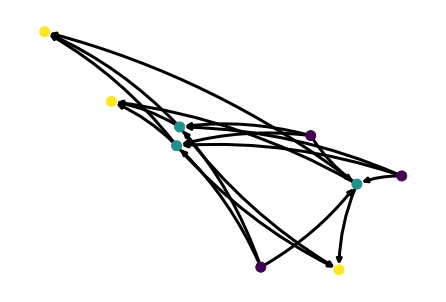

In [80]:
idx_s = [idx for idx, val in enumerate(s) if val == 1]
idx_m = [idx for idx, val in enumerate(m) if val == 1]
idx_d = [idx for idx, val in enumerate(d) if val == 1]

edges = []
G.clear_edges()
for i in idx_s:
    target = [j for j in range(N) if e[i,j] == 1]
    for j in target:
        edges.append((i, j))

for i in idx_m:
    source = [j for j in range(N) if e[j,i] == 1]
    target = [j for j in range(N) if e[i,j] == 1]
    for j in target:
        edges.append((i, j))

draw_graph(dict(G.nodes(data=True)), edges)